#NLP Project - IGLU challenge





## Install Huggingface transformers and other libraries 🤗


In [ ]:
!pip3 install transformers
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dataclasses import dataclass
import os
import datetime
import pickle
import numpy as np
import random
import torch
import pandas as pd
from torch.utils.data import TensorDataset
from transformers import BertTokenizer, RobertaTokenizer, BartTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import RobertaForSequenceClassification, BartForSequenceClassification
from tqdm.auto import tqdm

## Hyperparameters

In [ ]:
model_name = 'bart'
max_seq_length=128
batch_size=32
epoch=6
lr=3e-5
seed_val = 42

## Proprocessing - Tokenize the text data for BERT

In [ ]:
def get_tensor_dataset(df,tokenizer):
    
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    token_type_ids = []
    attention_masks = []
    labels = []
    topic_ids = []
    
    for count, item in tqdm(enumerate(zip(df["GameId"], 
                                          df['InputInstruction'], df["IsInstructionClear"])),
                            total=len(df), desc='Tokenizing data'):
        z, x, y = item
        encoded_dict = tokenizer.encode_plus(
                            x.lower(),
                            add_special_tokens = True, 
                            max_length = max_seq_length,           
                            pad_to_max_length = True,
                            truncation=True, 
                            return_attention_mask = True,   
                            return_tensors = 'pt',     
                       )

        input_ids.append(encoded_dict['input_ids'])

        if "token_type_ids" in encoded_dict:        
            token_type_ids.append(encoded_dict['token_type_ids'])

        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(y)

        topic_ids.append(z)
    

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return  TensorDataset(input_ids, attention_masks, labels)
    token_type_ids = []
    attention_masks = []
    labels = []
    topic_ids = []
    
    for count, item in tqdm(enumerate(zip(df["GameId"], 
                                          df['InputInstruction'], df["IsInstructionClear"])),
                            total=len(df), desc='Tokenizing data'):
        z, x, y = item
        encoded_dict = tokenizer.encode_plus(
                            x.lower(),
                            add_special_tokens = True, 
                            max_length = max_seq_length,           
                            pad_to_max_length = True,
                            truncation=True, 
                            return_attention_mask = True,   
                            return_tensors = 'pt',     
                       )

        input_ids.append(encoded_dict['input_ids'])

        if "token_type_ids" in encoded_dict:        
            token_type_ids.append(encoded_dict['token_type_ids'])

        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(y)

        topic_ids.append(z)
    

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return  TensorDataset(input_ids, attention_masks, labels)

In [ ]:
from sklearn.model_selection import train_test_split

data_path='public_data/clarifying_questions_train.csv'
df = pd.read_csv(data_path, sep=",")
dftrain, dfdev = train_test_split(df, test_size=0.15)
dfdev.to_csv('public_data/clarifying_questions_val.csv', index=False)

for df in [dfdev,dftrain]:

  if df.shape ==dfdev.shape:
    data_type='dev'
  else:
    data_type='train'  
  

  df['IsInstructionClear'] = df.IsInstructionClear.replace({'Yes': 0, 'No': 1})

  #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
  #tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  dataset = get_tensor_dataset(df,tokenizer) 

  tensor_data=f"{model_name}_{data_type}.pkl"
  with open(tensor_data, 'wb') as f:
      pickle.dump(dataset, f)
      
tokenizer.save_pretrained("saved_tokenizer")

Tokenizing data:   0%|          | 0/1025 [00:00<?, ?it/s]

Tokenizing data:   0%|          | 0/5803 [00:00<?, ?it/s]

('saved_tokenizer/tokenizer_config.json',
 'saved_tokenizer/special_tokens_map.json',
 'saved_tokenizer/vocab.json',
 'saved_tokenizer/merges.txt',
 'saved_tokenizer/added_tokens.json')

## Train Classifier 🏋️‍♀️

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def train_model( model_name, model, train_dataloader, scheduler, optimizer, criterion, epochs, lr):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    if torch.cuda.is_available():    
        device = torch.device("cuda")

    else:
        device = torch.device("cpu")
    print(device)

    # For each epoch...
    for epoch in range(epochs):
        
        total_train_loss = 0
        train_n_correct = 0
        nb_tr_examples = 0

        model.train()

        for _, batch in tqdm(enumerate(train_dataloader), 
                             total=len(train_dataloader),
                             desc=f'Train epoch {epoch+1}/{epochs}'):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            result = model(b_input_ids, attention_mask=b_input_mask)

            loss = criterion(result.logits, b_labels)
            loss.backward()
            total_train_loss += loss.item()
            
            optimizer.step()
            scheduler.step()

            logits = result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            _, _, _, accuracy = eval_result(logits, label_ids) 
            train_n_correct += accuracy
            nb_tr_examples+=b_input_ids.size(0)
        
        avg_train_loss = total_train_loss / len(train_dataloader)            
        train_acc = train_n_correct / len(train_dataloader)


        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f} '.format(epoch+1, epochs, avg_train_loss, train_acc  ))

    print("Training complete!")

    model.save_pretrained(f"saved_model/{model_name}_{epochs}e_{lr}lr")
    model.save_pretrained(f"drive/MyDrive/IGLU-cq-data/{model_name}_{epochs}e_{lr}lr")

In [ ]:
def eval_result(preds, labels):
    """ Calculate the accuracy, f1, precision, recall of our predictions vs labels
    """

    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = np.sum(y_pred == y_true) / len(y_true) 

    return (precision, recall, f1, accuracy)

from sklearn.metrics import classification_report

def eval_model( model, epoch,lr,test_dataloader):
    
    if torch.cuda.is_available():    
        device = torch.device("cuda")
        model.cuda()
    else:
        device = torch.device("cpu")


    model.eval()

    test_results = []
    test_labels = []
    test_results_predicted_lavels = [] 
    for batch in tqdm(test_dataloader, desc='Eval model'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            result = model(b_input_ids, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        logits = logits.detach().cpu().numpy()
        test_results.extend(logits.tolist())
        tmp = np.asarray(logits.tolist())
        test_results_predicted_lavels.extend(np.argmax(tmp, axis=1).flatten())
        label_ids = b_labels.to('cpu').numpy()
        test_labels.extend(label_ids)

    print(classification_report( np.asarray(test_labels), np.asarray(test_results_predicted_lavels)))
    (precision, recall, f1, accuracy) = eval_result(np.asarray(test_results), np.asarray(test_labels))

    print('Test Precision: {:.4f}, Test Recall: {:.4f}, Test Macro F1: {:.4f}, Test Accuracy: {:.4f} ' .format(precision, recall, f1, accuracy))

    df = pd.DataFrame(test_results, columns=["0", "1"])

    df['y_True'] = test_labels
    #print(df.head())
    df.to_csv( f"Final_Test_Probanility_Distribution_{model_name}_{epoch}e_{lr}lr_eval.csv", index=False)
    return np.asarray(test_results), np.asarray(test_labels)

In [ ]:
print("============================================================")
print(f" {epoch} -- {lr} -- {datetime.datetime.now()}")
print("============================================================")

with open(f'{model_name}_train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size, 
            num_workers= 4
        )

model = BartForSequenceClassification.from_pretrained(
        "facebook/bart-base",
        num_labels=2,
    )

#if model_name == 'bart':
#    model = BartForSequenceClassification.from_pretrained(
#        "facebook/bart-base",
#        num_labels=2,
#    )
#elif model_name == 'roberta':
#    print("test2")
#    model = RobertaForSequenceClassification.from_pretrained(
#        "roberta-base",
#        num_labels=2,
#    )
#else:
#    model = BertForSequenceClassification.from_pretrained(
#        'bert-base-uncased',
#        num_labels=2,
#    )
model.cuda()

optimizer = AdamW(
    model.parameters(),
    lr = lr,
)


criterion = CrossEntropyLoss()
total_steps = len(train_dataloader) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Train Model
train_model( model_name,model, train_dataloader, scheduler, optimizer, criterion, epoch, lr)

 6 -- 3e-05 -- 2022-12-09 18:48:55.258602


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


Train epoch 1/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [1/6], Train Loss: 0.3253, Train Accuracy: 0.8814 


Train epoch 2/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [2/6], Train Loss: 0.2898, Train Accuracy: 0.8996 


Train epoch 3/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [3/6], Train Loss: 0.2757, Train Accuracy: 0.9023 


Train epoch 4/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [4/6], Train Loss: 0.2639, Train Accuracy: 0.9053 


Train epoch 5/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [5/6], Train Loss: 0.2471, Train Accuracy: 0.9105 


Train epoch 6/6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch [6/6], Train Loss: 0.2296, Train Accuracy: 0.9145 
Training complete!


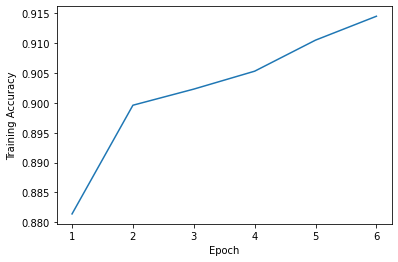

In [ ]:
import matplotlib.pyplot as plt

loss = [0.3253, 0.2898, 0.2757, 0.2639, 0.2471, 0.2296]
epoch = [1,2,3,4,5,6]
accuracy = [0.8814,0.8996, 0.9023, 0.9053,0.9105, 0.9145]
plt.plot(epoch, accuracy)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

## Evaluate classifier

In [ ]:
model = BartForSequenceClassification.from_pretrained(f"saved_model/{model_name}_{epoch}e_{lr}lr")
with open(f"{model_name}_dev.pkl", 'rb') as f:
    test_dataset = pickle.load(f)

    test_dataloader = DataLoader(
                test_dataset,  
                sampler = RandomSampler(test_dataset), 
                batch_size = batch_size 
    )
    preds, all_labels =  eval_model( model, epoch,lr,test_dataloader)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Eval model:   0%|          | 0/33 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       887
           1       0.68      0.50      0.58       138

    accuracy                           0.90      1025
   macro avg       0.80      0.73      0.76      1025
weighted avg       0.89      0.90      0.89      1025

Test Precision: 0.6765, Test Recall: 0.5000, Test Macro F1: 0.7593, Test Accuracy: 0.9005 


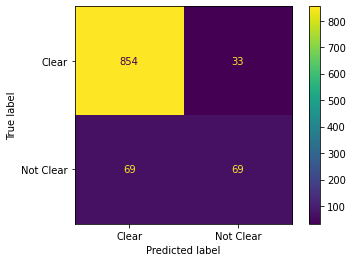

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
preds = np.argmax(preds, axis=1)
cm = confusion_matrix(all_labels, preds)
labels = ["Clear", "Not Clear"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

# Ranking using BM25 - "What to ask as a clarifying question" 📝

We'll not train any model for this baseline, we'll simply use BM25 with is already a strong ranker. 

What's your ideas to improve scores above BM25? 😉

## Installing requirements and dependencies



In [ ]:
!pip install pytrec_eval
!pip install rank_bm25
!pip install ast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrec-eval: filename=pytrec_eval-0.5-cp38-cp38-linux_x86_64.whl size=263228 sha256=286ed9d6c83ccada0c8e88b6697398e368f0398b5dba849cb2caa6e55f4488a2
  Stored in directory: /root/.cache/pip/wheels/65/5a/e7/115104a6d6ebacea7cbd7434fdba04bd06b6756820994a326e
Successfully built pytrec-eval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement ast (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for ast


In [ ]:
import pandas as pd
from statistics import mean
import os 
import logging
import os
import sys
import random
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
import nltk
from nltk.stem.porter import PorterStemmer
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

def stem_tokenize(text, remove_stopwords=True):
  stemmer = PorterStemmer()
  tokens = [word for sent in nltk.sent_tokenize(text) \
                                      for word in nltk.word_tokenize(sent)]
  tokens = [word for word in tokens if word not in \
          nltk.corpus.stopwords.words('english')]
  return [stemmer.stem(word) for word in tokens]

np.random.seed(42)
random.seed(42)


logging.basicConfig(
  level=logging.INFO,
  format="%(asctime)s [%(levelname)s] %(message)s",
  handlers=[
      logging.StreamHandler(sys.stdout)
  ]
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataloader


In [ ]:
from sklearn.model_selection import train_test_split
#selecting part of data for dev set for testing
data_path='public_data/clarifying_questions_train.csv'
df = pd.read_csv(data_path, sep=",")

test = df.drop(columns=['InitializedWorldPath','IsInstructionClear','Partition'])
test = test[~test["ClarifyingQuestion"].isnull()]

#preprocessing question bank for BM25
question_bank_path = 'public_data/question_bank.csv'
question_bank = pd.read_csv(question_bank_path).fillna('')
question_bank['tokenized_question_list'] = question_bank['ClarifyingQuestion'].map(stem_tokenize)
question_bank['tokenized_question_str'] = question_bank['tokenized_question_list'].map(lambda x: ' '.join(x))

## Run BM25

We'll use the 'qrel' column of the dataset to create a corpus to rank from. Then use BM25 to rank each question for every input instruction that has a clarifying question in the dataset.

In [ ]:
import ast
print(test.head())
run_file_path = 'dev_bm25'
run_file= open(run_file_path, 'w')
for index, row in test.iterrows():
    list_of_qs=ast.literal_eval(test['qbank'][index]) 
    GameId= test['GameId'][index]
    temp_q_bank=question_bank[question_bank['qrel'].isin(list_of_qs)]
    bm25_corpus = temp_q_bank['tokenized_question_list'].tolist() #creating a seperate corpus for each GameId
    bm25 = BM25Okapi(bm25_corpus)
    #print(temp_q_bank.head())
    top_k=len(bm25_corpus)
    # Runs bm25 for every query and stores output in file.
    examples = []
    all_preds_bm25 = []
    query = test.loc[test['GameId']==GameId, 'InputInstruction'].tolist()[0]
    bm25_ranked_list = bm25.get_top_n(stem_tokenize(query, True), 
                                    bm25_corpus, 
                                    n=top_k)
    bm25_q_list = [' '.join(sent) for sent in bm25_ranked_list]
    docs = temp_q_bank.set_index('tokenized_question_str').loc[bm25_q_list, 'ClarifyingQuestion'].tolist()
    preds = temp_q_bank.set_index('tokenized_question_str').loc[bm25_q_list, 'qrel'].tolist()
    for i, questionid in enumerate(preds):
        #writing results to runfile
        run_file.write('{} 0 {} {} {} BM25-reranker\n'.format(GameId,questionid, i+1, (len(preds)-i)/100))

run_file.close()

          GameId                                 ClarifyingQuestion  \
3   CQ-game-1000                                Which color blocks?   
5   CQ-game-1002  After you remove the one green block there are...   
16  CQ-game-1011              in any square west of the red blocks?   
25  CQ-game-1020             Should I destory east or west puyrple?   
55  CQ-game-1055        Where exactly am I placing the blue blocks?   

                                     InputInstruction   qrel  \
3   Place four blocks to the east of the highest b...  q_149   
5   facing north destroy a green block located on ...  q_436   
16  Stack seven green blocks immediately to the we...  q_111   
25  Facing north place one purple block to the lef...  q_653   
55  facing northdelete top 2 purple blocks on Righ...  q_170   

                                                qbank  
3   'q_696', 'q_203', 'q_516', 'q_677', 'q_769', '...  
5   'q_928', 'q_46', 'q_191', 'q_462', 'q_400', 'q...  
16  'q_101', 'q_186'

## Evaluate on whole dataset

Since there is no training step, here we evaluate BM25 entire dataset.

In [ ]:
# evalauting run_file_path in terms of MRR@5,10,20
topic_df = test
topic_question_set_dict = topic_df.groupby('GameId')['qrel'].agg(set).to_dict()
ambigous_questions_count=0
for v in topic_question_set_dict.values():
    ambigous_questions_count+= len(v)

run_df = pd.read_csv(run_file_path, sep=' ', header=None)
run_df = run_df.sort_values(by=[0, 4], ascending=False).drop_duplicates(subset=[0, 4], keep='first')
run_question_set_list = run_df.groupby(0)[2].agg(list).to_dict()
topk_list = [5, 10, 20]

mrr_score_dict = {}

for topk in topk_list:
    metric_name = 'MRR{}'.format(topk)
    mrr_score_dict[metric_name] = {}
    for tid in topic_question_set_dict:
        try: 
            qrel= list(topic_question_set_dict[tid])[0]
            rr= 1/ (run_question_set_list[tid][:topk].index(qrel) + 1 )
        except: 
            rr=0
        
        mrr_score_dict[metric_name][tid] = rr

mean_performance = {}
for metric in mrr_score_dict:
    mean_performance[metric] = sum(mrr_score_dict[metric][k] for k in mrr_score_dict[metric])/ambigous_questions_count
    
for metric in mrr_score_dict:
    print('{}: {}'.format(metric, mean_performance[metric]))

MRR5: 0.32202247191011213
MRR10: 0.33552434456928826
MRR20: 0.34432871423613903


#ClariQ dataset